In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
#!unzip -uq "/content/drive/My Drive/summer2winter_yosemite.zip" -d "/content/drive/My Drive/"

In [ ]:
# Funzionalità per il caricamento e la trasformazione delle immagini
import os
import torch
from torch.utils.data import DataLoader
import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms

# Funzioni per la visualizzazione
import matplotlib.pyplot as plt
import numpy as np
import warnings

%matplotlib inline

In [ ]:
# Funzione per il caricamento dei DataLoader per training e test set.
#
# image_type: "summer" o "winter", indica il nome delle directory in cui
# sono contenute le immagini delle classi X e Y.
# 
# image_dir: nome della directory principale in cui sono contenute le 
# sotto-directory di training e test.
#
# image_size: dimensione delle immagini scalate.
#
# batch_size: numero delle immagini contenute in un batch.

def get_data_loader(image_type, image_dir='summer2winter_yosemite', 
                    image_size=128, batch_size=16, num_workers=0):
  
    """Le immagini vengono scalate a 128x128x3 (per deafult), convertite in tensori
       e normalizzate.
    """
    
    # Resize e normalizzazione
    transform = transforms.Compose([transforms.Resize(image_size), # resize a 128x128
                                    transforms.ToTensor()])

    # Accedo alle directory di training e test
    image_path = '/content/drive/My Drive/' + image_dir
    train_path = os.path.join(image_path, image_type)
    test_path = os.path.join(image_path, image_type)

    # Definiamo i dataset
    train_dataset = datasets.ImageFolder(train_path, transform)
    test_dataset = datasets.ImageFolder(test_path, transform)

    # Creiamo i DataLoaders
    train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)
    test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)

    return train_loader, test_loader

In [ ]:
def data_loader_train_test(image_type, image_dir='summer2winter', 
                    image_size=128, batch_size=16, num_workers=0):
  
   # Resize e normalizzazione
  transform = transforms.Compose([transforms.Resize(image_size), # resize a 128x128
                                  transforms.ToTensor()])
  
  # Accedo alle directory di training e test
  image_path = '/content/drive/My Drive/' + image_dir
  train_path = os.path.join(image_path, image_type + "_train")
  test_path = os.path.join(image_path, image_type + "_test")

  # Definiamo i dataset
  train_dataset = datasets.ImageFolder(train_path, transform)
  test_dataset = datasets.ImageFolder(test_path, transform)

  # Creiamo i DataLoaders
  train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)
  test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)

  return train_loader, test_loader

In [ ]:
# Creiamo i dataloader per le immagini dei due domini X e Y.
#dataloader_X, test_dataloader_X = get_data_loader(image_type='summer')
#dataloader_Y, test_dataloader_Y = get_data_loader(image_type='winter')

In [ ]:
dataloader_X, test_dataloader_X = data_loader_train_test(image_type='summer')
dataloader_Y, test_dataloader_Y = data_loader_train_test(image_type='winter')

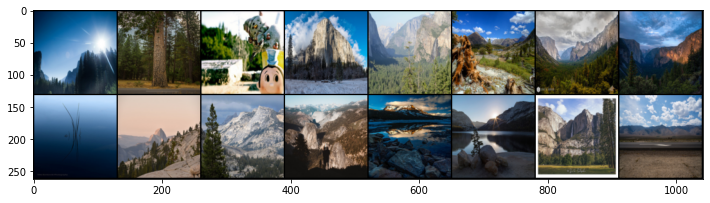

In [ ]:
# Display delle immagini
# Funzione che effettua un reshape delle immagini
# e le converte in NumPy per poterle plottare.

def imshow(img):
  npimg = img.numpy() # 3x262x1042
  plt.imshow(np.transpose(npimg, (1, 2, 0))) # 3x262x1042 ---> 262x1042x3

# Immagini dal dominio X (summer)
dataiter = iter(dataloader_X)
images, _ = dataiter.next() # 16x3x128x128

# Display
fig = plt.figure(figsize=(12, 8))
imshow(torchvision.utils.make_grid(images)) # Creo una griglia 2*8

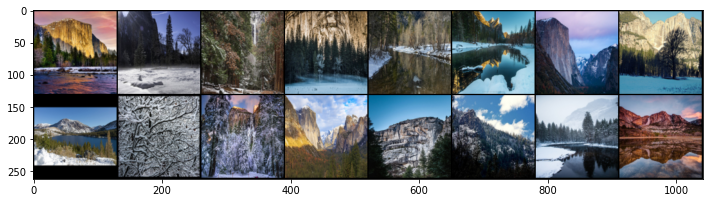

In [ ]:
# Display immagini classe Y (winter)
dataiter = iter(dataloader_Y)
images, _ = dataiter.next()

# Show
fig = plt.figure(figsize=(12,8))
imshow(torchvision.utils.make_grid(images))

In [ ]:
# Pre-processing delle immagini: sapendo che la funzione di attivazione
# tanh (utilizzata nel generatore) fornisce immagini i cui pixel variano tra
# -1 ed 1, dobbiamo prima normalizzare l'intervallo delle immagini di training
# (in questo momento i pixel variano tra 0 ed 1).

# Range corrente
img = images[0]
print("Min: ", img.min())
print("Max: ", img.max())

Min:  tensor(0.0078)
Max:  tensor(0.9843)


In [ ]:
# Funzione di normalizzazione: essa prende in ingresso un'immagine x
# e ritorna la stessa immagine con i valori dei pixel tra -1 ed 1.
def scale(x, feature_range=(-1,1)):
  min, max = feature_range
  x = x * (max-min) + min
  return x

In [ ]:
scaled_img = scale(img)
print("Scaled min: ", scaled_img.min())
print("Scaled max: ", scaled_img.max())

Scaled min:  tensor(-0.9843)
Scaled max:  tensor(0.9686)


# **Discriminatori**
Una CycleGAN è composta da due discriminatori e
da due generatori. 
I discriminatori, Dx e Dy, sono rappresentati da delle CNN, le quali ricevono in input un'immagine e provano a classificarla come reale o fake. In questo caso, l'output "reale" è indicato dal valore 1, mentre l'output "fake" dal valore 0. 
L'architettura dei discriminatori è mostrata nella seguente figura:

 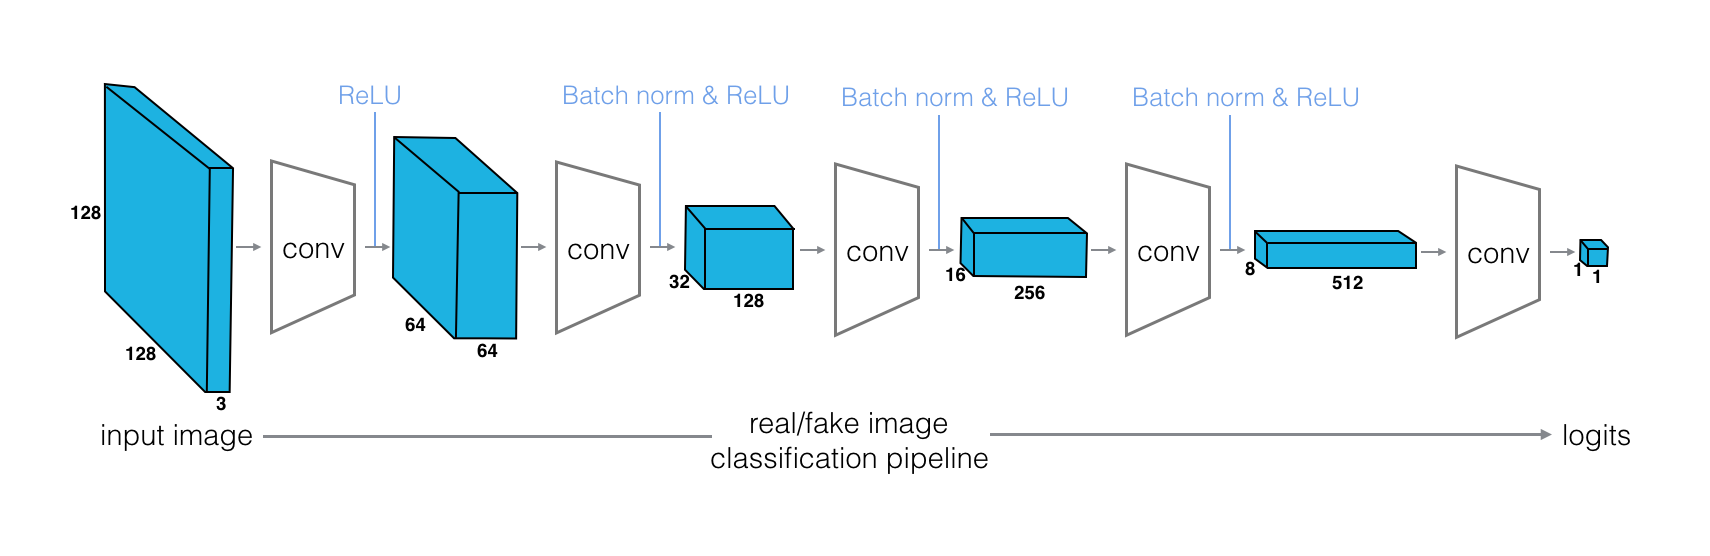

 La rete vede un'immagine 128x128x3 che viene computata attraverso 5 layer convolutivi che sotto-campionano l'immagine di un fattore 2 (l'immagine quindi viene scalata). I primi 4 layer possiedono come funzioni di attivazioni la ReLU e la BatchNorm (che vengono applicate all'output di ogni layer), mentre l'ultimo layer si comporta da classificatore, per cui fornisce in output un unico valore.

In [ ]:
# Per definire i discriminatori dobbiamo prima creare i layer
# convolutivi + gli eventuali layer di batch normalization.

import torch.nn as nn 
import torch.nn.functional as F 

def conv(in_channels, out_channels, kernel_size, stride = 2, padding = 1, batch_norm = True):
  layers = []
  conv_layer = nn.Conv2d(in_channels = in_channels, out_channels = out_channels,
                         kernel_size = kernel_size, stride = stride, padding = padding, bias = False)
  
  layers.append(conv_layer)

  # Aggiungo il layer di batch norm (solo per i primi 4
  # layer convolutivi).
  if batch_norm:
    layers.append(nn.BatchNorm2d(out_channels))
  return nn.Sequential(*layers)

NOTA: in generale, settare un padding P = (kernel_size - 1)/2 quando lo stride S = 1 assiura che l'input e l'output del layer convolutivo avranno le stesse dimensioni spaziali. 

In [ ]:
# Definiamo l'architettura del discriminatore. Utilizziamo
# un'unica classe poichè l'architettura è analoga sia per
# Dx che per Dy. 
# NOTA: è raccomandato utilizzare una KERNEL_SIZE = 4x4
# ed utilizzarla per determinare le size corrette per i parametri
# di stride e padding per ciascun layer. 

class Discriminator(nn.Module):

  def __init__(self, conv_dim = 64):
    super(Discriminator, self).__init__()

    # Layer convolutivi (il primo non possiede la batch norm)
    # L'output di ogni layer avrà una dimensione pari a: NxNxconv_dim*(fattore_moltiplicativo),
    # dove N = (input_size - kernel_size + 2*padding_size)/stride + 1.
    self.conv1 = conv(3, conv_dim, 4, batch_norm = False) # 128x128x3 ---> 64x64x64
    self.conv2 = conv(conv_dim, conv_dim * 2, 4) # 64x64x64 ---> 32x32x128
    self.conv3 = conv(conv_dim*2, conv_dim*4, 4) # 32x32x128 ---> 16x16x256
    self.conv4 = conv(conv_dim*4, conv_dim*8, 4) # 16x16x256 ---> 8x8x512

    # Layer di classificazione (applichiamo un kernel di dimensione pari a quella
    # dell'output del precedente layer, stride unitario e padding nullo)
    self.conv5 = conv(conv_dim*8, 1, 8, stride = 1, padding = 0, batch_norm = False) # 8x8x512 ---> 1x1x1

  
  def forward(self, x):
    # ReLU applicata in tutti i layer convolutivi, meno quello di classificazione
    out = F.relu(self.conv1(x))
    out = F.relu(self.conv2(out))
    out = F.relu(self.conv3(out))
    out = F.relu(self.conv4(out))
    # Layer di classificazione
    out = self.conv5(out)
    return out

  # NOTA: non applichiamo la funzione sigmoidea all'output di ciascun layer
  # poichè in seguito durante il training useremo una error loss function quadratica.

# **Generatori**
I generatori, G_XtoY e G_YtoX (denominati spesso G ed F) sono costituiti da un **encoder**, una CNN responsabile di trasformare un'immagine in un tensore di feature di piccole dimensioni, e da un **decoder**, quest'ultima una CNN trasposta che si occupa di ri-trasformare tale tensore in un'immagine. Questi generatori possiedono la seguente architettura:

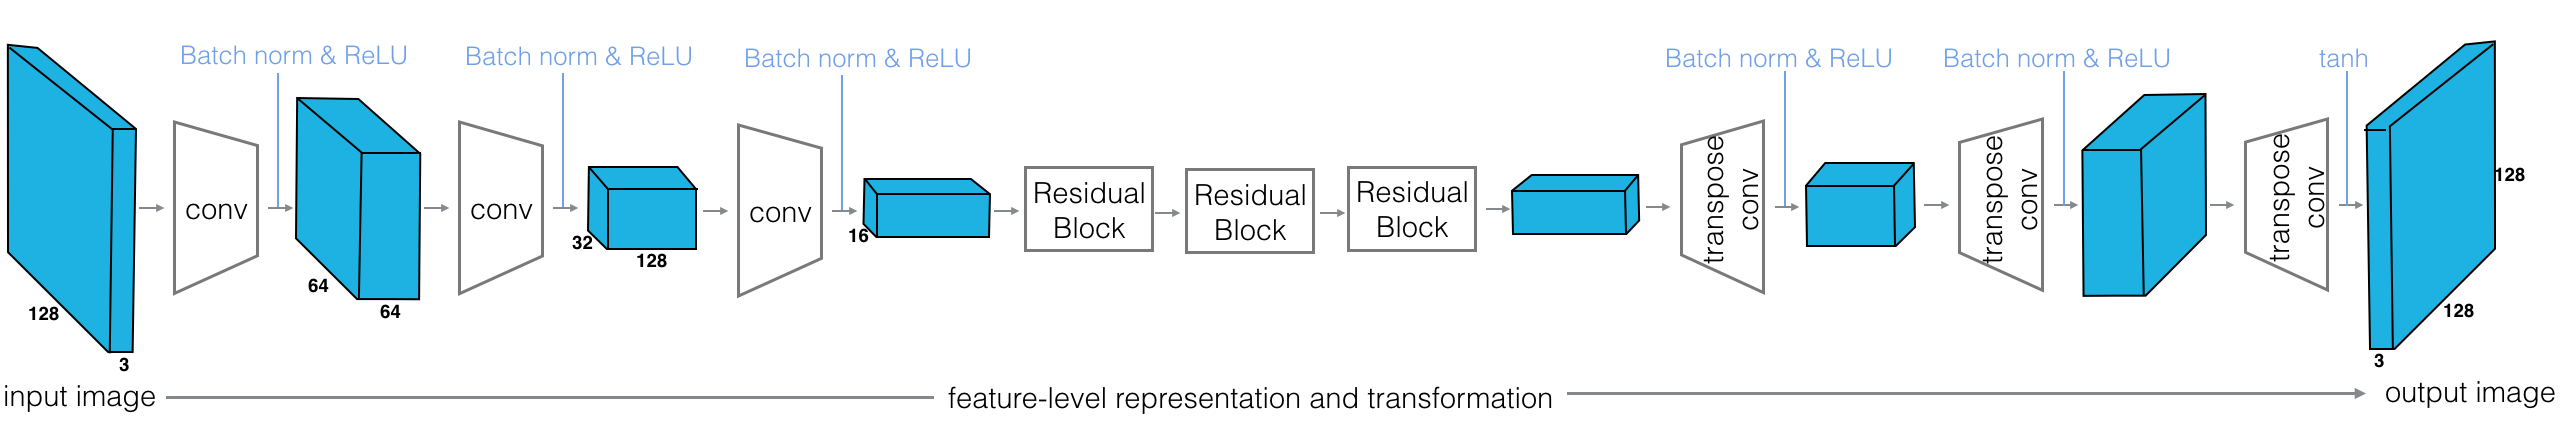

Questa rete riceve in input un immagine 128x128x3 e la comprime in un tensore di feature dopo aver attraversato 3 layer convolutivi. Questo vettore viene poi computato da una serie di **blocchi residui** (**residual blocks**, tipicamente 6 o più) ed infine 3 layer convolutivi trasposti sovra-campionano l'output di questi blocchi per creare una nuova immagine. 
Si nota dalla figura come i layer convolutivi standard e trasposti applicano la batch normalization e la ReLu function ai loro output, ad eccezione dell'ultimo layer convolutivo trasposto che applica la funzione tanh. 

# **Residual Blocks**
I blocchi residui (Resnet blocks) si basano sulla connessione dell'output di un layer con l'input di un layer precedente. Questi layer si utilizzano nel caso di reti neurali con molti layer (deep neural networks) per risolvere il problema dei gradienti evanescenti o "esplosivi", in modo da evitare problemi di instabilità durante la fase di addestramento (quando l'accuratezza satura o addirittura peggiora nelle successive epoche).

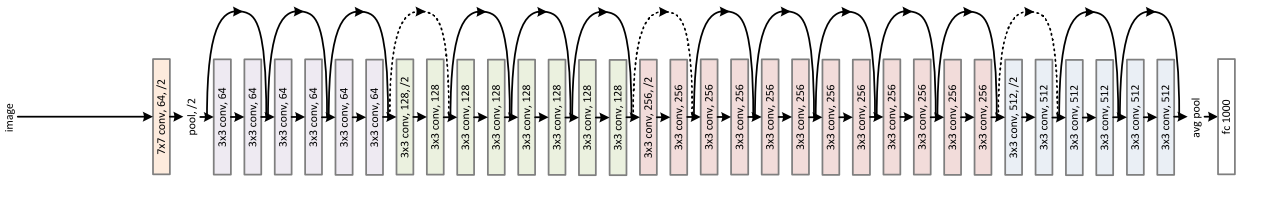

Una soluzione a questo problema consiste appunto nell'utilizzare i blocchi residui che ci consentono di apprendere le cosiddette "funzioni residue" (**residual functions**).
La seguente figura mostra il funzionamento di un blocco residuo:

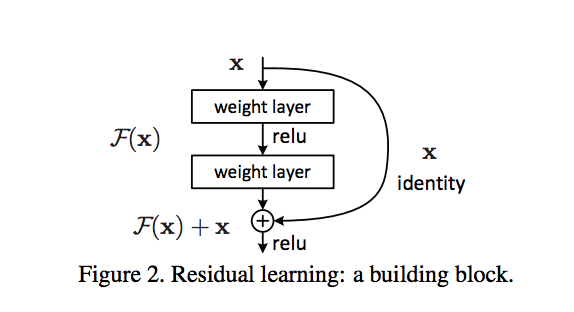

In genere un modello di rete neurale, costituito da diversi layer ciascuno dei quali utilizza delle funzioni di attivazione, è in grado di imparare una funzione di mapping M da un input x ad un output y:
- M(x) = y

Invece di imparare questo mapping diretto tra x ed y è possibile definire una **funzione residua** come:
- F(x) = M(x) - x

Tale funzione tipicamente si ottiene dalla combinazione di 2 layer convolutivi + 1 layer di normalizzazione e la funzione ReLU applicata tra di essi (come mostrato in figura). I layer convolutivi devono avere lo stesso numero di ingressi e di uscite.
La funzione di mapping M quindi può essere riscritta nel seguente modo:
- M(x) = y = F(x) + x

L'operatore di somma "+" crea una sorta di loop che collega l'input x all'output y.
L'utilizzo della funzione residua è giustificato dal fatto che essa è più facile da ottimizzare durante il ciclo di training rispetto all'ottimizzazione della funzione di mapping completa M(x).



In [ ]:
# Un ResidualBlock viene definito in questo caso come:
#   - 2 layer convolutivi con lo stesso numero di input ed output
#   - 1 layer di batch normalization applicato agli output dei layer convolutivi
#   - 1 ReLu function applicata all'output del primo layer convolutivo
# Questi blocchi permettono al modello di imparare effettivamente la trasformazione
# di un'immagine da un dominio ad un altro.

class ResidualBlock(nn.Module):

  def __init__(self, conv_dim):
    super(ResidualBlock, self).__init__()
    # conv_dim = numero di input = numero output del layer precedente
    # La batch normalization si comporta in questo caso da funzione residua F(x)
    # Poichè vogliamo che i layer convolutivi abbiano lo stesso numero di 
    # input ed output utilizziamo un kernel 3x3, stride = 1 e padding = 1.
    self.conv_layer1 = conv(in_channels = conv_dim, out_channels = conv_dim, 
                            kernel_size = 3, stride = 1, padding = 1, batch_norm = True)
    
    self.conv_layer2 = conv(in_channels = conv_dim, out_channels = conv_dim, 
                            kernel_size = 3, stride = 1, padding = 1, batch_norm = True)
    
  def forward(self, x):
    out_1 = F.relu(self.conv_layer1(x))
    out_2 = x + self.conv_layer2(out_1) # output = x + resnet_block(x)
    return out_2

In [ ]:
# Funzione per la creazione di un layer convolutivo trasposto

def deconv(in_channels, out_channels, kernel_size, stride = 2, padding = 1, batch_norm = True):
  layers = []
  layers.append(nn.ConvTranspose2d(in_channels, out_channels, kernel_size, stride, padding, bias = False))
  # Layer di batch normalization (opzionale)
  if batch_norm:
    layers.append(nn.BatchNorm2d(out_channels))
  return nn.Sequential(*layers)


In [ ]:
# Definiamo l'architettura del generatore.
# NOTA: i generatori G ed F hanno la stessa architettura, per cui
# è sufficiente definire un'unica classe ed istanziare i generatori
# successivamente nella creazione effettiva del modello.

class CycleGenerator(nn.Module):

  def __init__(self, conv_dim = 64, n_res_blocks = 6):
    super(CycleGenerator, self).__init__()

    # 1. Definiamo l'encoder
    self.conv1 = conv(3, conv_dim, 4)
    self.conv2 = conv(conv_dim, conv_dim*2, 4)
    self.conv3 = conv(conv_dim*2, conv_dim*4, 4)

    # 2. Definiamo la Resnet
    res_layers = []
    for layer in range(n_res_blocks):
      res_layers.append(ResidualBlock(conv_dim*4))
    self.res_blocks = nn.Sequential(*res_layers)

    # 3. Definiamo il decoder
    self.deconv1 = deconv(conv_dim*4, conv_dim*2, 4)
    self.deconv2 = deconv(conv_dim*2, conv_dim, 4)
    # Non si applica la batch normalization all'ultimo layer
    self.deconv3 = deconv(conv_dim, 3, 4, batch_norm = False)

  def forward(self, x):
    # Data un'immagine x, restituisce un'immagine trasformata
    
    out = F.relu(self.conv1(x))
    out = F.relu(self.conv2(out))
    out = F.relu(self.conv3(out))

    out = self.res_blocks(out)

    out = F.relu(self.deconv1(out))
    out = F.relu(self.deconv2(out))
    # tanh applicata all'ultimo layer
    out = F.tanh(self.deconv3(out))

    return out

In [ ]:
# Creazione della CycleGAN completa

def create_model(g_conv_dim = 64, d_conv_dim = 64, n_res_blocks = 6):

  # Istanziamo i discriminatori
  D_X = Discriminator(conv_dim = d_conv_dim) # Discrimina le immagini di classe X
  D_Y = Discriminator(conv_dim=d_conv_dim) # Discrimina le immagini di classe Y

  # Istanziamo i generatori
  G_XtoY = CycleGenerator(conv_dim=g_conv_dim, n_res_blocks=n_res_blocks) # Da summer a winter
  G_YtoX = CycleGenerator(conv_dim=g_conv_dim, n_res_blocks=n_res_blocks) # Da winter a summer

  # Spostiamo i modelli nella GPU
  if torch.cuda.is_available():
    device = torch.device("cuda:0")
    G_XtoY.to(device)
    G_YtoX.to(device)
    D_X.to(device)
    D_Y.to(device)
    print('Modelli spostati sulla GPU.')
  else:
    print('GPU non disponibile.')
  
  return G_XtoY, G_YtoX, D_X, D_Y

In [ ]:
# Creiamo i modelli
G_XtoY, G_YtoX, D_X, D_Y = create_model()
# Load parameters (optional)
#checkpoint_dir='checkpoints_cyclegan'
#G_XtoY_path = os.path.join(checkpoint_dir, 'G_XtoY.pkl')
#G_YtoX_path = os.path.join(checkpoint_dir, 'G_YtoX.pkl')
#D_X_path = os.path.join(checkpoint_dir, 'D_X.pkl')
#D_Y_path = os.path.join(checkpoint_dir, 'D_Y.pkl')
#G_XtoY = torch.load(G_XtoY_path)
#G_YtoX = torch.load(G_YtoX_path)
#D_X = torch.load(D_X_path)
#D_Y = torch.load(D_Y_path)

Modelli spostati sulla GPU.


CycleGenerator(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): Sequential(
    (0): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (res_blocks): Sequential(
    (0): ResidualBlock(
      (conv_layer1): Sequential(
        (0): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (conv_layer2): Sequential(
        (0): Conv2d(256, 256, kernel_size=(3, 3), stride=(

In [ ]:
# Check per verificare la correttezza dei modelli
def print_models(G_XtoY, G_YtoX, D_X, D_Y):

  # Stampa le informazioni dei modelli
  print("                     G_XtoY                    ")
  print("-----------------------------------------------")
  print(G_XtoY)
  print()

  print("                     G_YtoX                    ")
  print("-----------------------------------------------")
  print(G_YtoX)
  print()

  print("                      D_X                      ")
  print("-----------------------------------------------")
  print(D_X)
  print()

  print("                      D_Y                      ")
  print("-----------------------------------------------")
  print(D_Y)
  print()

print_models(G_XtoY, G_YtoX, D_X, D_Y)

                     G_XtoY                    
-----------------------------------------------
CycleGenerator(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): Sequential(
    (0): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (res_blocks): Sequential(
    (0): ResidualBlock(
      (conv_layer1): Sequential(
        (0): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
   

# **Funzioni di errore per Discriminatore e Generatore**
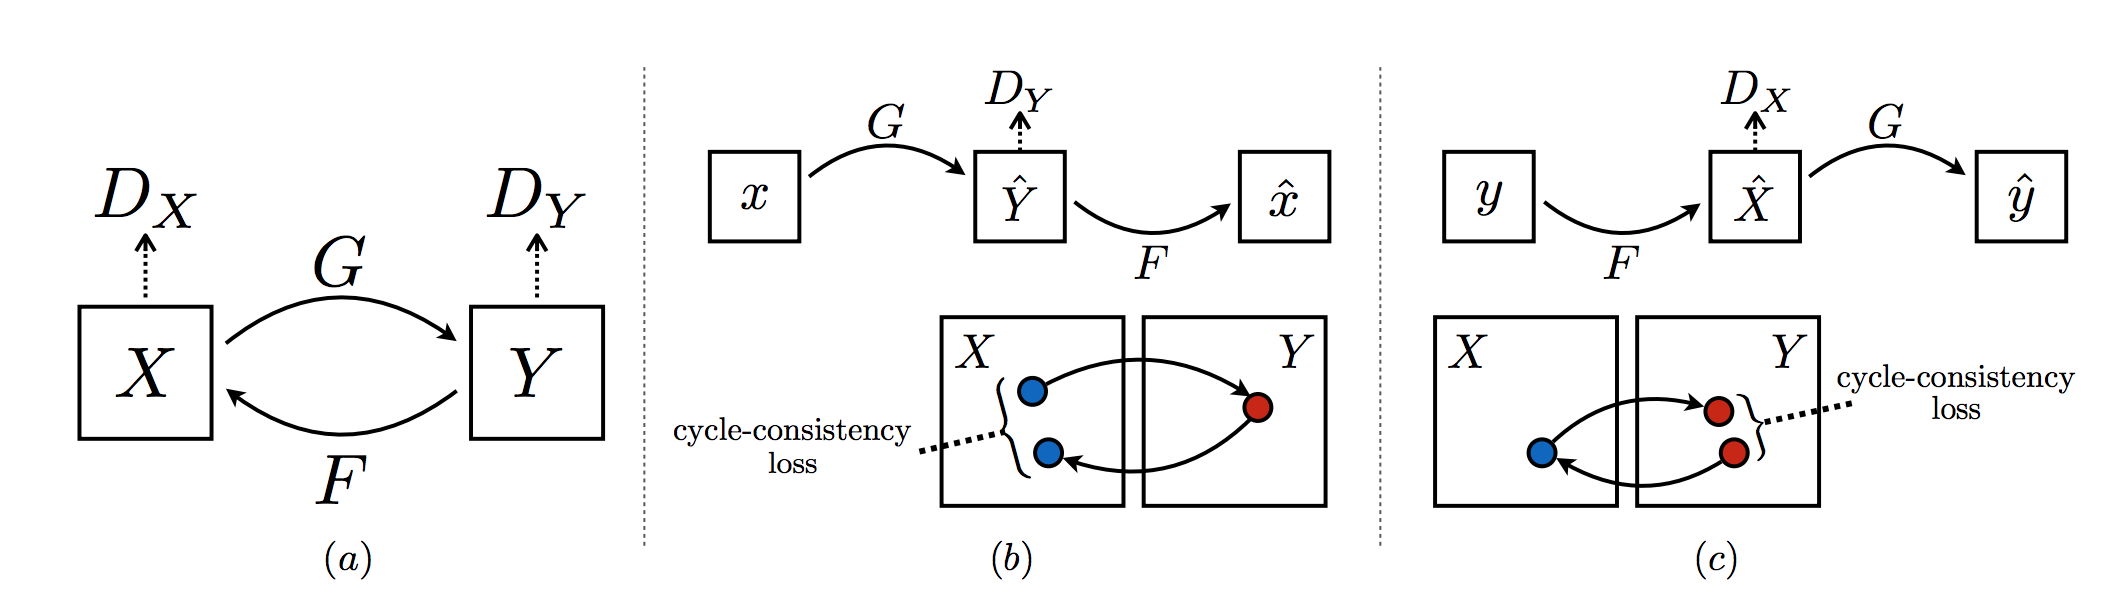

- La CycleGAN contiene due funzioni di mapping: G: X -> Y e F: Y -> X, e i discriminatori avversari associati D_Y e D_X. D_Y spinge G a trasformare le immagini della classe X in immagini indistinguibili da quelle del dominio Y, e viceversa per D_X ed F.

- Per ottimizzare ulteriormente queste trasformazioni si introducono 2 **cycle consistency losses** le quali catturano l'idea che se si trasforma un'immagine dal dominio X al dominio Y, e successivamente si trasforma quest'ultima nel dominio X si dovrebbe ottenere l'immagine di partenza (le funzioni G ed F quindi devono essere l'una inversa dell'altra). Queste funzioni di errore vengono chiamate **Forward cycle-cosistency loss** (da X a Y) e **Backward cycle-consistency loss** (da Y ad X).

In una GAN standard il discriminatore viene visto come un classificatore che applica la funzione sigmoidea all'output generato e la funzione di errore di cross entropia per distinguere tra i campioni veri e quelli falsi. Tuttavia, tale funzione di errore si è visto che porta al problema dei gradienti evanescenti durante il training, per cui per superare questo problema si è deciso di far uso della **funzione di loss dei minimi quadrati** per i discriminatori della CycleGAN. Una tale rete neurale viene spesso definita come **LSGAN** (Least Square GAN). Gli autori di questo modello hanno dimostrato che questo tipo di funzione di errore è più stabile durante la fase di addestramento e permette di generare immagini di migliore qualità.

- Esempio: data un'immagine reale x, il discriminatore D_X viene addestrato valutando l'errore quadratico medio (mean squared error) applicato alla differenza tra l'output generato dal discriminatore e il valore target (in questo caso 1 = True):


```
out_x = D_X(x)
real_err = torch.mean((out_x-1)**2)
```

L'errore del generatore (sia esso G o F) viene calcolato sulla base dell'output fornito dal discriminatore associato (D_Y o D_X) quando esso riceve in input l'immagine fake generata. Il generatore tenderà a minimizzare tale errore per "ingannare" il discriminatore, inducendolo a classificare l'immagine generata come autentica.

Come detto in precedenza, oltre al calcolo di queste funzioni di errore, i generatori dovranno includere un ulteriore termine dato dalla **cycle consistency loss**. Questo errore è una misura di quanto buona è un'immagine ricostruita (F(G(x)) o G(F(x))) quando questa viene confrontata con quella originale.
Per questo confronto si raccomanda l'utilizzo della funzione di loss L1 (norma unitaria) la quale calcola una differenza assoluta tra l'immagine ricostruita e quella originale. E' possibile poi moltiplicare questo errore per un peso *lambda* che valuta il suo grado di importanza. 

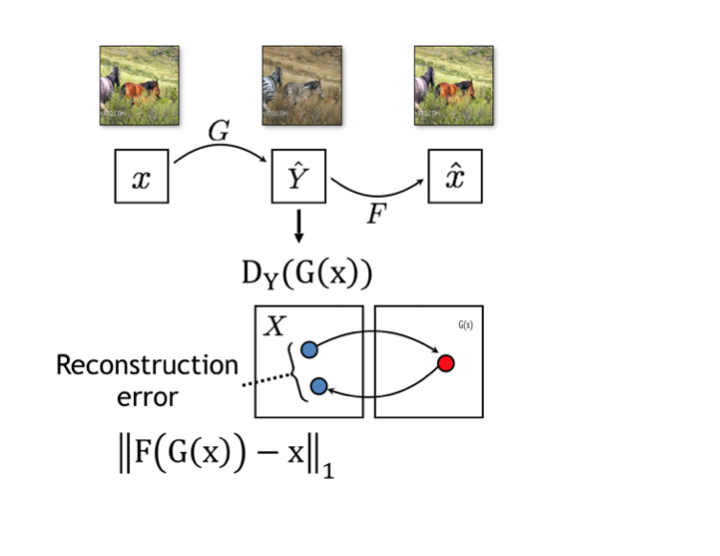




In [ ]:
# Definiamo le funzioni di errore che utilizzeremo durante il training.

# Errore quadratico medio applicato all'output del
# discriminatore quando l'input x è reale
def real_mse_loss(D_out):
  return torch.mean((D_out - 1)**2)

# Errore quadratico medio applicato all'output del
# discriminatore quando l'input x è fake
def fake_mse_loss(D_out):
  return torch.mean(D_out**2)

# Errore medio assoluto valutato su un set di immagini reali
# ed un set di immagini ricostruite/generate. Il parametro lambda
# serve a pesare tale errore per un batch di immagini.
def cycle_consistency_loss(real_im, reconstructed_im, lambda_weight = 10):
  reconstr_loss = torch.mean(torch.abs(real_im - reconstructed_im))
  return lambda_weight*reconstr_loss

In [ ]:
# Definiamo gli ottimizzatori per l'aggiornamento dei pesi
import torch.optim as optim

# Iper-parametri per l'Adam optimizer
# Utilizziamo gli stessi valori di default
# che hanno scelto gli autori dell'articolo.
lr = 0.0002
beta1 = 0.5
beta2 = 0.999

# Ricavo i parametri dei generatori
g_params = list(G_XtoY.parameters()) + list(G_YtoX.parameters())

# Creo gli ottimizzatori per i generatori e i discriminatori
g_optimizer = optim.Adam(g_params, lr, [beta1, beta2])
d_x_optimizer = optim.Adam(D_X.parameters(), lr, [beta1, beta2])
d_y_optimizer = optim.Adam(D_Y.parameters(), lr, [beta1, beta2])

# **Training CycleGAN**
L'addestramento di una CycleGAN procede con i seguenti step:

**Training per i Discriminatori:**

1. Si calcola l'errore del discriminatore *D_X* quando riceve immagini reali.
2. Si generano immagini fake simili a quelle del dominio *X* utilizzando il generatore *F*.
3. Si calcola l'errore del discriminatore *D_X* quando riceve immagini fake.
4. Si calcola l'errore toale e si esegue la backpropagation per ottimizzare *D_X*.
5. Si ripetono gli step 1-4 con *D_Y* e i domini al contrario.

**Training per i Generatori:**

1. Si generano immagini fake simili a quelle del dominio *X* utilizzando il generatore *F*.
2. Si calcola l'errore del generatore sulla base dell'output fornito dal discriminatore *D_X* quando questo riceve in input l'immagine fake *X*.
3. Si genera l'immagine ricostruita *Ŷ* (utilizzando il generatore *G*) a partire dall'immagine fake *X* generata allo step 1.
4. Si calcola la cycle consistency loss confrontando le immagini ricostruite con le immagini reali *Y*.
5. Si ripetono gli step 1-4 con i domini al contrario.
6. Si sommano gli errori del generatore e della cycle consistency e si esegue la backpropagation per ottimizzare i parametri.

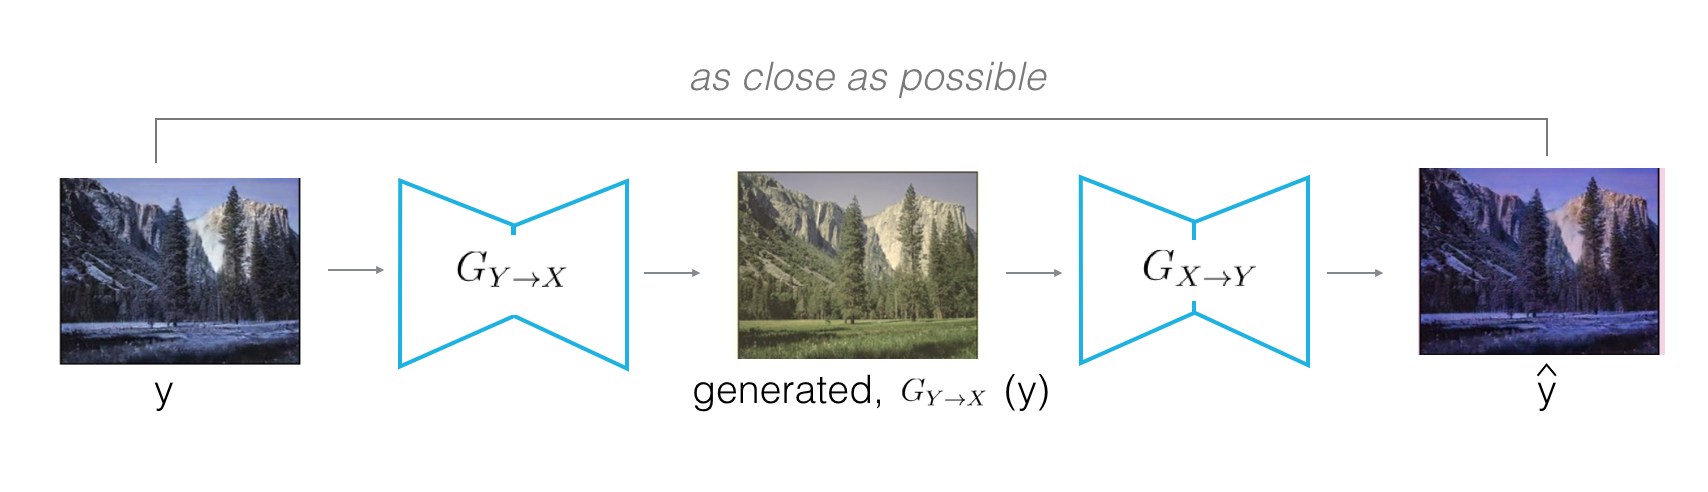

In [ ]:
# Alcune delle immagini generate dopo aver addestrato
# la CycleGAN per un certo numero di epoche vengono salvate
# in modo da capire il grado di accuratezza raggiunto.
# Inoltre, vengono salvati anche i parametri del modello
# in modo da poter riprendere l'addestramento in un secondo momento.
!cp drive/MyDrive/helpers.py .
from helpers import save_samples, save_reconstructed, checkpoint

In [ ]:
# Train del modello

def training_loop(dataloader_X, dataloader_Y, test_dataloader_X, test_dataloader_Y, n_epochs = 100):

  print_every = 10

  # Elenco degli errori durante l'addestramento
  losses = []

  test_iter_X = iter(test_dataloader_X)
  test_iter_Y = iter(test_dataloader_Y)

  # Ricaviamo alcune immagini costanti dai domini X ed Y per il campionamento.
  # Queste immagini durante l'addestramento ci permettono di capire le prestazioni
  # del modello.
  fixed_X = test_iter_X.next()[0] # 16x3x128x128
  fixed_Y = test_iter_Y.next()[0]
  # Scaliamo le immagini nel range [-1, 1]
  fixed_X = scale(fixed_X) 
  fixed_Y = scale(fixed_Y)

  # Numero di batch per epoca
  iter_X = iter(dataloader_X)
  iter_Y = iter(dataloader_Y)
  batches_per_epoch = min(len(iter_X), len(iter_Y)) # 75 batch da 16 immagini

  for epoch in range(1, n_epochs+1):

    # Resettiamo gli iteratori ogni 75 batch in modo
    # da scorrere da capo il dataset di training
    if epoch % batches_per_epoch == 0:
      iter_X = iter(dataloader_X)
      iter_Y = iter(dataloader_Y)
    
    # Immagini + scaling
    images_X, _ = iter_X.next()
    images_X = scale(images_X)
    images_Y, _ = iter_Y.next()
    images_Y = scale(images_Y)

    # Spostiamo le immagini sulla GPU se disponibile
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    images_X = images_X.to(device)
    images_Y = images_Y.to(device)


    # ============================================
    #            TRAINING DISCIMINATORI
    # ============================================

    # Addestramento per D_X: addestriamo prima
    # utilizzando le immagini reali.
    d_x_optimizer.zero_grad()
    out_x = D_X(images_X) # images_X = 1 batch da 16 immagini
    D_X_real_loss = real_mse_loss(out_x)

    # Addestriamo adesso il discriminatore
    # utilizzando le immagini generate.
    fake_X = G_YtoX(images_Y)
    out_x = D_X(fake_X)
    D_X_fake_loss = fake_mse_loss(out_x)

    # Sommiamo gli errori, propaghiamo l'errore ed aggiorniamo i parametri
    d_x_loss = D_X_real_loss + D_X_fake_loss
    d_x_loss.backward()
    d_x_optimizer.step()


    # Addestramento per D_Y (analogo al precedente)
    d_y_optimizer.zero_grad()
    out_y = D_Y(images_Y)
    D_Y_real_loss = real_mse_loss(out_y)

    fake_Y = G_XtoY(images_X)
    out_y = D_Y(fake_Y)
    D_Y_fake_loss = fake_mse_loss(out_y)

    d_y_loss = D_Y_real_loss + D_Y_fake_loss
    d_y_loss.backward()
    d_y_optimizer.step()


    # =========================================
    #            TRAINING GENERATORI
    # =========================================

    # Generiamo le immagini X fake e ricostruiamo le immagini Y.
    g_optimizer.zero_grad()
    fake_X = G_YtoX(images_Y)

    # Calcolo dell'errore del generatore:
    # utilizziamo la funzione real_mse_loss
    # perchè lo scopo è quello di generare 
    # immagini che sembrino reali.
    out_x = D_X(fake_X)
    g_YtoX_loss = real_mse_loss(out_x)

    # Creiamo l'immagine Y ricostruita
    reconstructed_Y = G_XtoY(fake_X)
    # Calcoliamo l'errore di cycle consistency
    reconstructed_y_loss = cycle_consistency_loss(images_Y, reconstructed_Y, lambda_weight=10)


    # Generiamo le immagini Y fake e ricostruiamo le immagini X.
    fake_Y = G_XtoY(images_X)

    # Calcolo dell'errore del generatore
    out_y = D_Y(fake_Y)
    g_XtoY_loss = real_mse_loss(out_y)

    # Creiamo l'immagine X ricostruita
    reconstructed_X = G_YtoX(fake_Y)
    # Calcoliamo l'errore di cycle consistency
    reconstructed_x_loss = cycle_consistency_loss(images_X, reconstructed_X, lambda_weight=10)


    # Sommiamo gli errori dei generatori e di cycle consistency
    # ed eseguiamo la backpropagation
    g_total_loss = g_YtoX_loss + g_XtoY_loss + reconstructed_y_loss + reconstructed_x_loss
    g_total_loss.backward()
    g_optimizer.step()


    # Stampa degli errori di training
    if epoch % print_every == 0:
      # Aggiungiamo gli errori alla lista
      losses.append((d_x_loss.item(), d_y_loss.item(), g_total_loss.item()))
      print("Epoca [{:5d}/{:5d}] | d_X_loss: {:6.4f} | d_Y_loss: {:6.4f} | g_total_loss: {:6.4f}"
      .format(epoch, n_epochs, d_x_loss.item(), d_y_loss.item(), g_total_loss.item()))

    
    sample_every = 100
    # Salva i campioni generati
    if epoch % sample_every == 0:
      # Settiamo i generatori in modalità eval
      G_YtoX.eval()
      G_XtoY.eval()
      # Vengono generate immagini prendendo i campioni di test
      save_samples(epoch, fixed_Y, fixed_X, G_YtoX, G_XtoY, batch_size=16)
      # Salviamo anche le immagini ricostruite
      save_reconstructed(epoch, fixed_X, fixed_Y, G_YtoX, G_XtoY, batch_size=16)
      # Resettiamo alla modalità training
      G_YtoX.train()
      G_XtoY.train()

    # Decommentare se si vuole salvare il modello
    checkpoint_every=1000
    # Salviamo i parametri del modello
    if epoch % checkpoint_every == 0:
        checkpoint(epoch, G_XtoY, G_YtoX, D_X, D_Y)

  return losses




In [ ]:
n_epochs = 4000
losses = training_loop(dataloader_X, dataloader_Y, test_dataloader_X, test_dataloader_Y, n_epochs=n_epochs)

OrderedDict([('conv1.0.weight',
              tensor([[[[ 1.2482e-01,  1.1344e-01,  6.8459e-02, -1.1501e-01],
                        [ 6.2959e-02,  1.3799e-02, -7.6435e-02,  1.2334e-01],
                        [-4.5974e-03, -2.4435e-02,  9.8052e-02,  9.3097e-02],
                        [ 1.0988e-01,  3.1807e-02,  1.1681e-01,  6.3290e-02]],
              
                       [[ 9.6918e-02,  1.0680e-01,  4.5183e-02,  8.8762e-02],
                        [ 1.0410e-01, -1.0279e-01, -2.5069e-02, -5.2012e-02],
                        [-6.8319e-02, -6.0092e-02,  1.8177e-02, -4.3662e-02],
                        [-1.3314e-01, -4.9779e-02,  1.2740e-01, -1.2347e-01]],
              
                       [[-1.0370e-01,  9.5259e-02, -3.5069e-02,  6.8851e-02],
                        [-8.3960e-02,  8.9730e-02, -7.9418e-02, -8.8447e-02],
                        [-9.6255e-02, -3.5494e-02, -5.6442e-02, -6.3371e-02],
                        [-8.4418e-02, -6.5954e-02, -1.0599e-01, -1.3491e-01]]]

# **Risultati**
Dai risultati possiamo notare come entrambi i discriminatori D_X e D_Y commettono degli errori nella classificazione delle immagini. Ciò è in accordo al task della CycleGAN, infatti il nostro compito è quello di progettare un modello che sia in grado di generare delle discrete immagini "fake" per entrambi i domini X ed Y. Vorremmo che il discriminatore (nel caso ideale) non sia in grado di scorgere alcuna differenza tra un'immagine reale ed una generata, per cui esso dovrebbe commettere sempre un errore di valutazione. 
Inoltre, bisogna assicurarsi che gli errori di D_X e D_Y siano pressochè uguali. Se non lo sono allora significa che il modello predilige un discriminatore piuttosto che l'altro (è in grado di generare immagini discrete solo per uno dei due domini), per cui bisogna modificare i bias della rete o dei dati.

Notiamo pure come l'errore del generatore all'inizio del training è molto più alto rispetto all'errore commesso dai discriminatori, questo perchè esso tiene conto degli errori di entrambi i generatori G ed F e anche degli errori di ricostruzione (cycle consistency losses). Inizialmente l'errore dei generatori diminuisce in modo abbastanza evidente (questo perchè all'inizio le immagini generate sono molto rumorose e lontane dalle corrispettive immagini reali), ma dopo un certo numero di epoche esso si stabilizza. Ciò accade in quanto sia i generatori che i disciminatori migliorano costantemente durante l'addestramento. 
Se invece si nota che l'errore di generazione aumenta di molto durante il training, allora si potrebbe provare a ridurre il Learning Rate o a modificare il valore del parametro *lambda* che pesa l'errore di consistenza di ciclo.

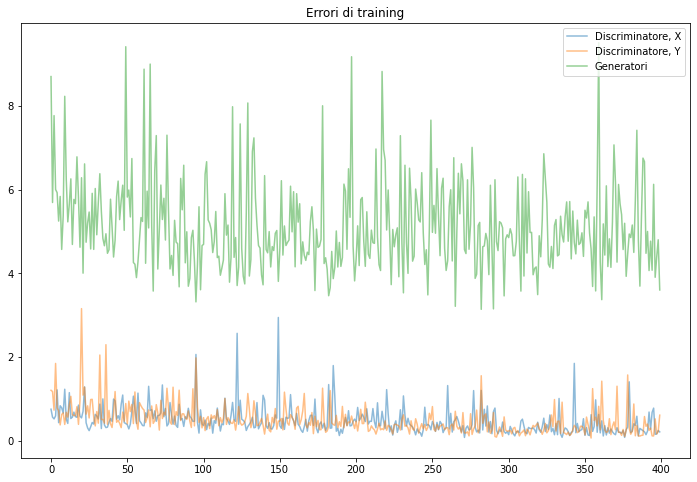

In [ ]:
# Plotting degli errori
fig, ax = plt.subplots(figsize=(12,8))
losses = np.array(losses)
plt.plot(losses.T[0], label='Discriminatore, X', alpha=0.5)
plt.plot(losses.T[1], label='Discriminatore, Y', alpha=0.5)
plt.plot(losses.T[2], label='Generatori', alpha=0.5)
plt.title("Errori di training")
plt.legend()

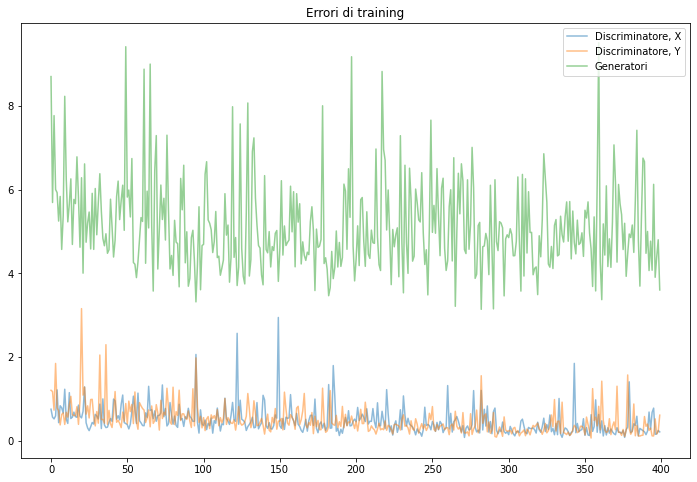

In [ ]:
# Funzione per il display dei campioni di immagini generate
import matplotlib.image as mpimg

# Il parametro "iteration" indica l'iterazione di training
# relativa alle immagini generate che si vogliono plottare.
def view_samples(iteration, sample_dir = 'samples_cyclegan'):

  # Nomi delle immagini da leggere
  path_XtoY = os.path.join(sample_dir, 'sample-{:06d}-X-Y.png'.format(iteration))
  path_YtoX = os.path.join(sample_dir, 'sample-{:06d}-Y-X.png'.format(iteration))

  # Lettura
  try:
    x2y = mpimg.imread(path_XtoY)
    y2x = mpimg.imread(path_YtoX)
  except:
    print("Numero di iterazione non valido.")
  
  fig, (ax1, ax2) = plt.subplots(figsize=(18,20), nrows=2, ncols=1, sharey=True, sharex=True)
  ax1.imshow(x2y)
  ax1.set_title("X ---> Y")
  ax2.imshow(y2x)
  ax1.set_title("Y ---> X")

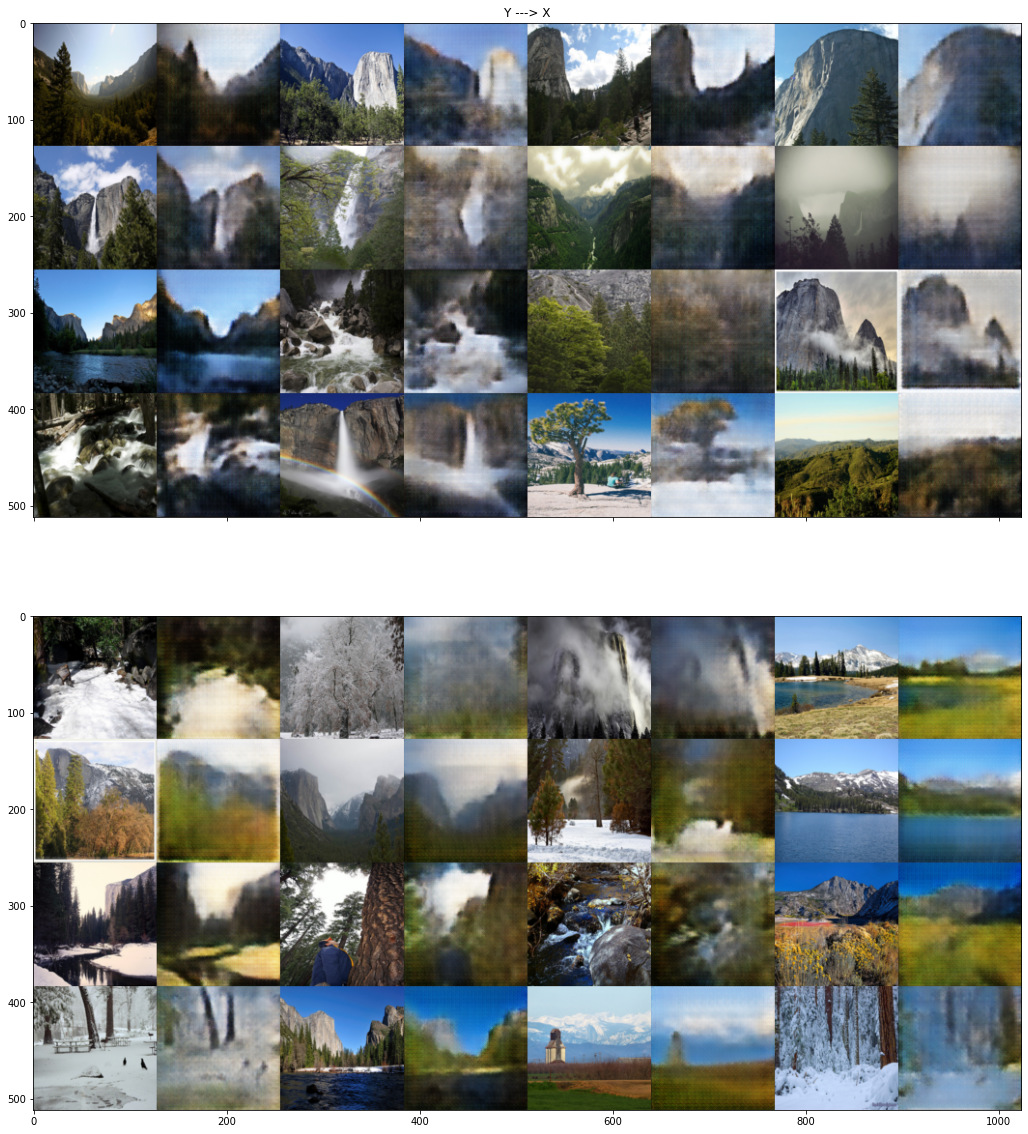

In [ ]:
# Visualizza i campioni ad una certa iterazione
iteration = 4000
view_samples(iteration)